# Correlation for a single GRB

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import popsynth
from popsynth.aux_samplers.trunc_normal_aux_sampler import TruncatedNormalAuxSampler
from popsynth.aux_samplers.lognormal_aux_sampler import LogNormalAuxSampler
from zusammen.synthetic_populations.aux_samplers import TDecaySampler, DurationSampler, LumSampler, EpeakObsSampler
%matplotlib widget
import cosmogrb

## Simulate one GRB in popsynth

In [2]:
pop_gen = popsynth.populations.SFRPopulation(r0=2/20, rise=1., decay=4.0,
                                             peak=1.5, r_max=7.0, a=0.1)

t90 = LogNormalAuxSampler(name="t90", observed=False)
t90.mu=np.log10(10)
t90.tau=0.25

ep = LogNormalAuxSampler(name="ep", observed=False)
ep.mu= np.log(300)
ep.tau=0.4

alpha = TruncatedNormalAuxSampler(name="alpha", observed=False)
alpha.lower=-1.5
alpha.upper=0.0
alpha.mu=-1
alpha.tau=0.25

ep_tau = TruncatedNormalAuxSampler(name="ep_tau", observed=False)
ep_tau.lower=-2
ep_tau.upper=-1
ep_tau.mu=-1.5
ep_tau.tau=0.25

nrest = LogNormalAuxSampler(name="nrest", observed=False)
nrest.mu = np.log(1e52)
nrest.tau = 0.1

gamma = TruncatedNormalAuxSampler(name="gamma", observed=False)
gamma.mu = 1.5
gamma.tau = 0.5
gamma.lower = 1.0
gamma.upper = 2.0

duration = DurationSampler()
obs_lum = LumSampler()
ep_obs = EpeakObsSampler()

duration.set_secondary_sampler(t90)
obs_lum.set_secondary_sampler(ep)
obs_lum.set_secondary_sampler(nrest)
obs_lum.set_secondary_sampler(gamma)
ep_obs.set_secondary_sampler(ep)

pop_gen.add_observed_quantity(duration)
pop_gen.add_observed_quantity(obs_lum)
pop_gen.add_observed_quantity(ep_obs)
pop_gen.add_observed_quantity(alpha)
pop_gen.add_observed_quantity(ep_tau)

In [3]:
population = pop_gen.draw_survey()
population.writeto('data/single_grb.h5')

Drawing distances:   0%|          | 0/2 [00:00<?, ?it/s]

 WARNING  |  NO HIDDEN OBJECTS 


## Define GRB

In [4]:
from corr_cpl.corr_cpl_source import CorrCPLSourceFunction
from corr_cpl.corr_cpl_grb import GBMGRB_CORR_CPL

In [5]:
grb = GBMGRB_CORR_CPL(
    ra=population.ra[0],
    dec=population.dec[0],
    z=population.distances[0],
    peak_flux=population.fluxes_latent[0],
    alpha=-0.66,
    ep=population.ep_obs[0],
    ep_tau=population.ep_tau[0],
    Nrest=population.nrest[0],
    gamma=population.gamma[0],
    duration=population.duration[0],
    T0=0.,
)

grb.info()

OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


,0
name,SynthGRB
z,1.93525
ra,327.353745
dec,-58.182886
duration,5.546546
T0,0.0


,0
peak_flux,2.274870e-06
alpha,-6.600000e-01
ep_tau,-1.188836e+00
Nrest,9.425503e+51
gamma,1.552661e+00


,0


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
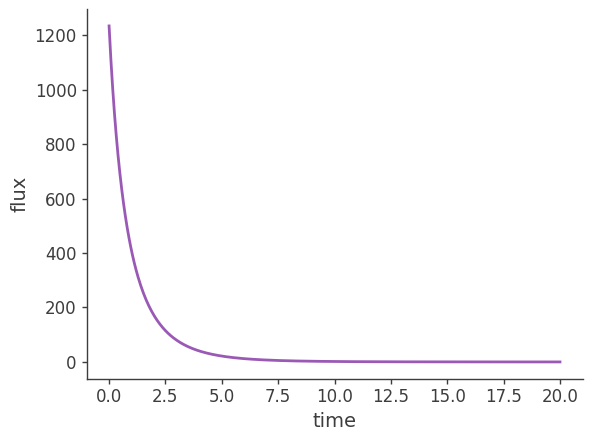

In [6]:
time = np.linspace(0, 20, 500)

grb.display_energy_integrated_light_curve(time);

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
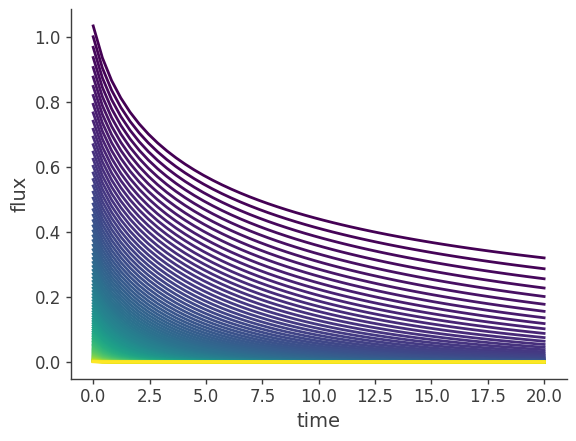

In [7]:
time = np.linspace(0, 20)
energy = np.logspace(1, 3, 100)

grb.display_energy_dependent_light_curve(time, energy, cmap='viridis')

Text(0, 0.5, 'flux')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
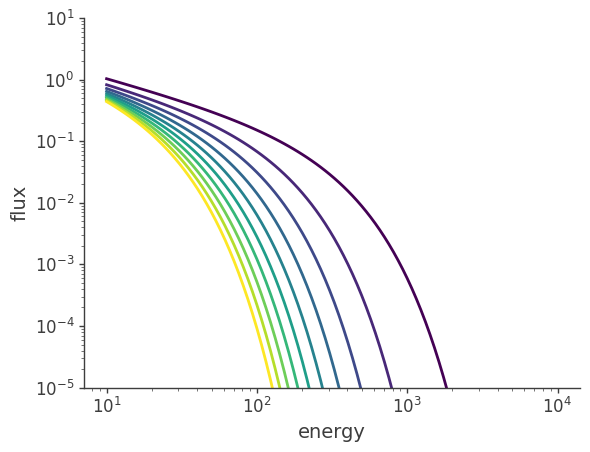

In [8]:
time = np.linspace(0, 10, 10)
energy = np.logspace(1, 4, 100)
out = list(grb._lightcurves.values())[0]._source._source_function.evolution(energy, 
                                                                            time)
fig, ax = plt.subplots()
for y, c in zip(out, plt.cm.viridis(np.linspace(0,1,len(out)))):
    ax.plot(energy, y, color=c)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1e-5, 1e1)
ax.set_xlabel('energy')
ax.set_ylabel('flux')

## Simulate GRB

In [9]:
grb.go(serial=True)
grb.save('data/test_grb.h5')

In [11]:
grb_reload = cosmogrb.GRBSave.from_file('data/test_grb.h5')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
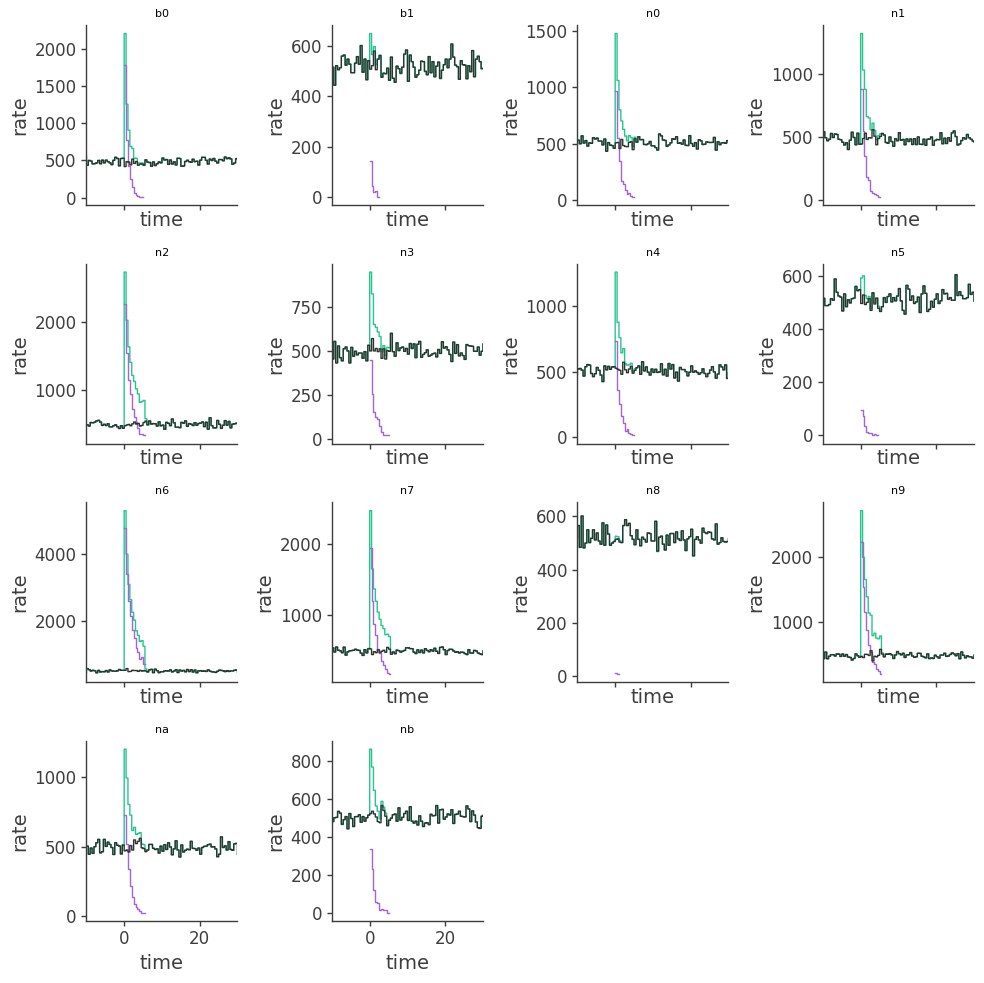

In [12]:
fig, axes = plt.subplots(4,4,sharex=True,sharey=False,figsize=(10,10))
row=0
col = 0
for k,v  in grb_reload.items():
    ax = axes[row][col]

    lightcurve =v['lightcurve']

    lightcurve.display_lightcurve(dt=.5, ax=ax,lw=1,color='#25C68C')
    lightcurve.display_source(dt=.5,ax=ax,lw=1,color="#A363DE")
    lightcurve.display_background(dt=.5,ax=ax,lw=1, color="#2C342E")
    ax.set_xlim(-10, 30)
    ax.set_title(k,size=8)



    if col < 3:
        col+=1
    else:
        row+=1
        col=0

axes[3,2].set_visible(False)
axes[3,3].set_visible(False)
plt.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
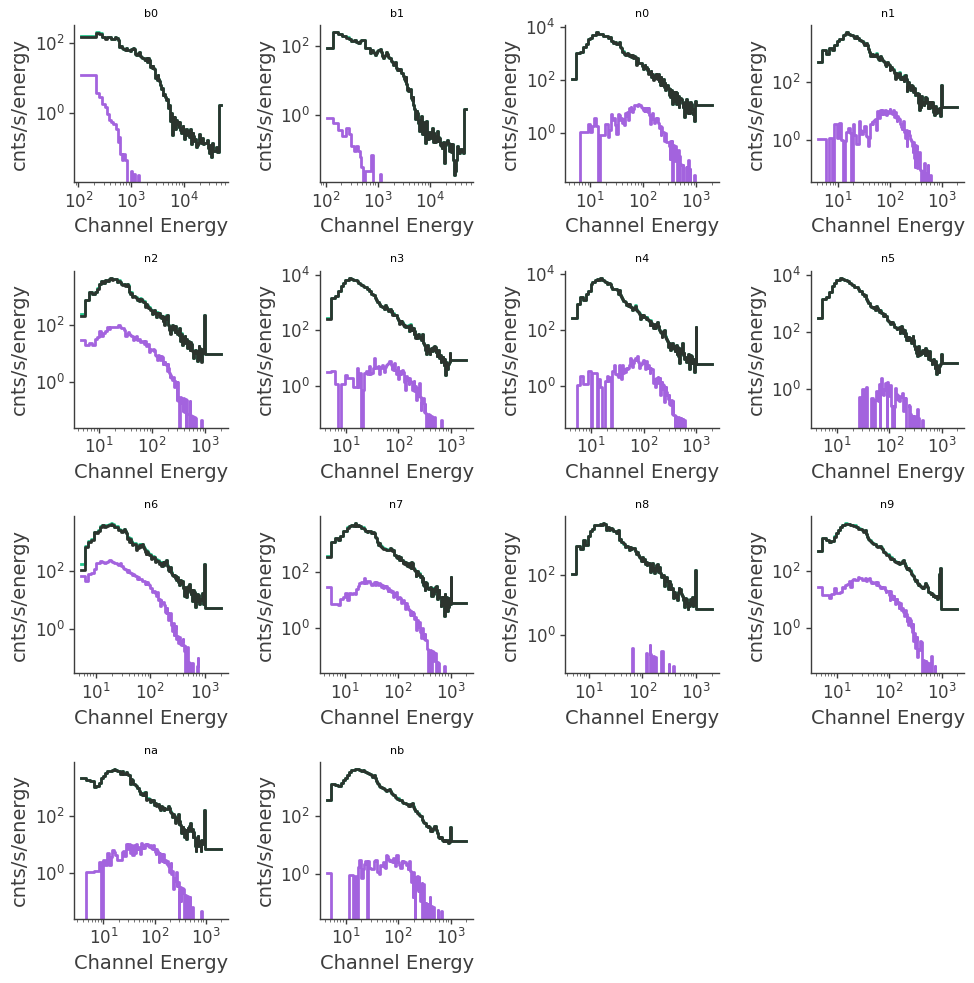

In [13]:
fig, axes = plt.subplots(4,4,sharex=False,sharey=False,figsize=(10,10))
row=0
col = 0

for k, v in grb_reload.items():
    ax = axes[row][col]

    lightcurve = v['lightcurve']

    lightcurve.display_count_spectrum(tmin=0, tmax=5, ax=ax,color='#25C68C')
    lightcurve.display_count_spectrum_source(tmin=0, tmax=5, ax=ax,color="#A363DE")
    lightcurve.display_count_spectrum_background(tmin=0, tmax=5, ax=ax, color="#2C342E")
    ax.set_title(k,size=8)

    if col < 3:
        col+=1
    else:
        row+=1
        col=0

axes[3,2].set_visible(False)
axes[3,3].set_visible(False)
plt.tight_layout()

## Simulate universe

In [14]:
from corr_cpl.corr_cpl_universe import GBM_CORR_CPL_Universe

In [15]:
universe = GBM_CORR_CPL_Universe('data/single_grb.h5', save_path="data")

universe.go(client=None)

universe.save('data/survey.h5')

## View survey

In [16]:
from cosmogrb.universe.survey import Survey

In [17]:
survey = Survey.from_file('data/survey.h5')
survey.info()

,0
n_grbs,2
is_processed,False


In [18]:
survey['SynthGRB_1'].grb

name                                                SynthGRB_1
z                                                     1.531545
ra                                                    21.53132
dec                                                   6.645068
duration                                              6.723785
T0                                                         0.0
Nrest        1004324921271246093864227873332257712710223536...
alpha                                                -0.919598
ep_start                                            232.898162
ep_tau                                               -1.309219
gamma                                                 1.352133
peak_flux                                             0.000007

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
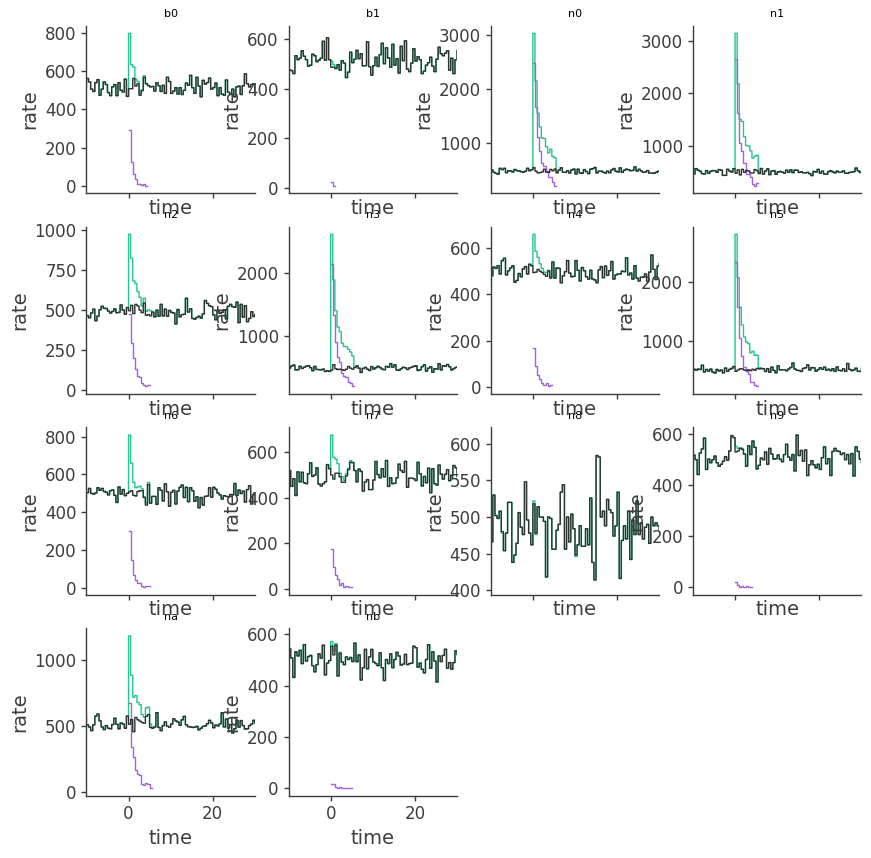

In [20]:
fig, axes = plt.subplots(4,4,sharex=True,sharey=False,figsize=(10,10))
row=0
col = 0
for k,v  in survey['SynthGRB_0'].grb.items():
    ax = axes[row][col]

    lightcurve =v['lightcurve']

    lightcurve.display_lightcurve(dt=.5, ax=ax,lw=1,color='#25C68C')
    lightcurve.display_source(dt=.5,ax=ax,lw=1,color="#A363DE")
    lightcurve.display_background(dt=.5,ax=ax,lw=1, color="#2C342E")
    ax.set_xlim(-10, 30)
    ax.set_title(k,size=8)



    if col < 3:
        col+=1
    else:
        row+=1
        col=0

axes[3,2].set_visible(False)
axes[3,3].set_visible(False)

## Logging

In [13]:
import logging
logger = logging.getLogger("cosmogrb")
logger.setLevel(logging.DEBUG)
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
logger.addHandler(ch)